In [1]:
#importing libraries
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import cv2

In [2]:
#function to create masks
def create_mask(img1,img2,version,smoothing_window_size=800):
    #parameters of the image
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2
    
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    #mask if the image is left image
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ), (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        #mask if the image is right image
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ), (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    
    return cv2.merge([mask, mask, mask])

#function to stitch images
def Image_Stitching(img1,img2):
   
    #lowe's ratio
    ratio=0.85
    min_match=10
    
    sift=cv2.SIFT_create()
 
    #get key points and descriptors from both images
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    # compute the all matches using euclidean distance and opencv provide 


    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    raw_matches = flann.knnMatch(des1,des2,k=2)

    
    
    
    
    #filter good points using Lowe's ratio
    good_points = []
    good_matches=[]
    for m1, m2 in raw_matches:
        if m1.distance < ratio * m2.distance:
            #append good points indexes
            good_points.append((m1.trainIdx, m1.queryIdx))
            good_matches.append([m1])
  
    
   
    #at least 10 good matches
    if len(good_points) > min_match:
        #get key points from indexes values
        image1_kp = np.float32(
            [kp1[i].pt for (_, i) in good_points])
        image2_kp = np.float32(
            [kp2[i].pt for (i, _) in good_points])
        
        
        #get homography matrix H that maps image 2  to image 1 plane
        H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)




    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2

    #stitch and blend images using masks and H
    
    panorama1 = np.zeros((height_panorama, width_panorama, 3))
    mask1 = create_mask(img1,img2,version='left_image')
    panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
    panorama1 *= mask1
    mask2 = create_mask(img1,img2,version='right_image')
    #wrap img2 to img using matrix H and give weight using mask
    panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
    result=panorama1+panorama2/(mask1+mask2)

    #get the values which are not null
    rows, cols = np.where(result[:, :, 0] != 0)
    min_row, max_row = min(rows), max(rows) + 1
    min_col, max_col = min(cols), max(cols)  + 1 
    final_result = result[min_row:max_row, min_col:max_col, :]
    final_result=final_result.astype('uint8')
    
    return final_result

In [4]:

imageA=cv2.imread('a1.jpg')
imageB=cv2.imread("a2.jpg")
imageC=cv2.imread("a3.jpg")

result=Image_Stitching(imageA,imageB)
fresult=Image_Stitching(result,imageC)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
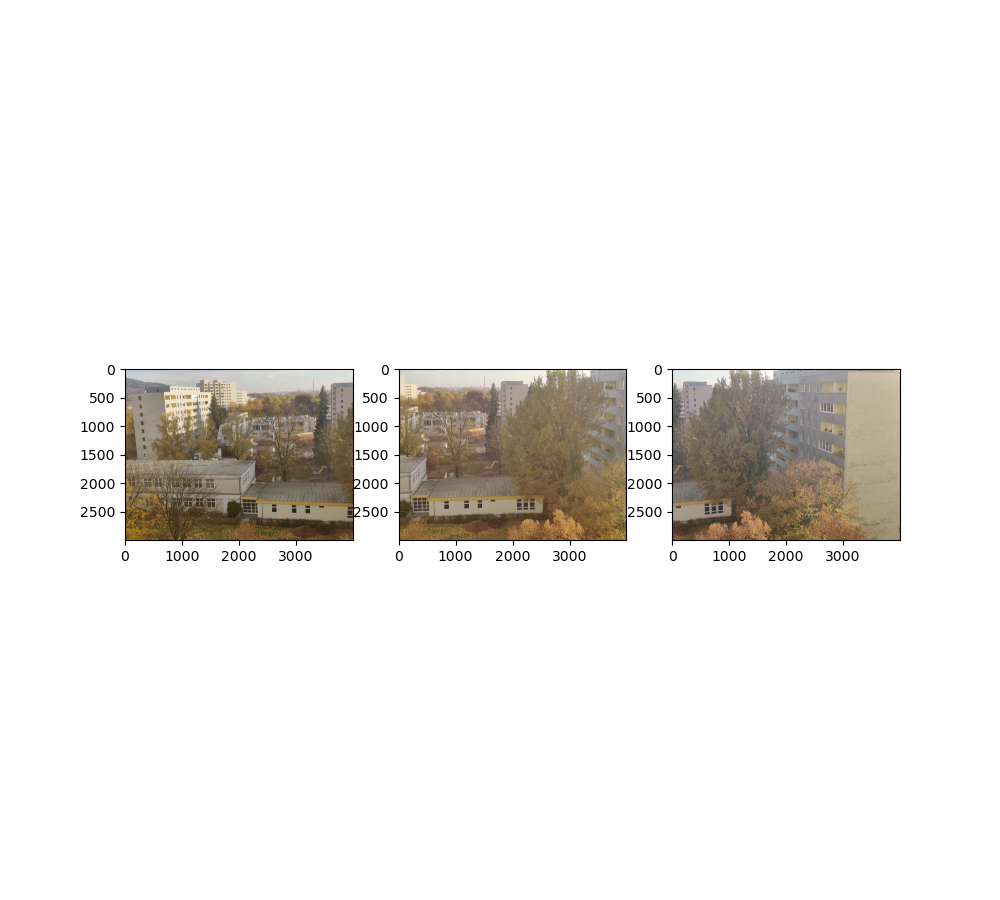

In [5]:
#shows three input images
fig, ax = plt.subplots(1,3, figsize=(10,9))
imageA=cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB)
imageB=cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB)
imageC=cv2.cvtColor(imageC,cv2.COLOR_BGR2RGB)

ax[0].imshow(imageA)
ax[1].imshow(imageB)
ax[2].imshow(imageC)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
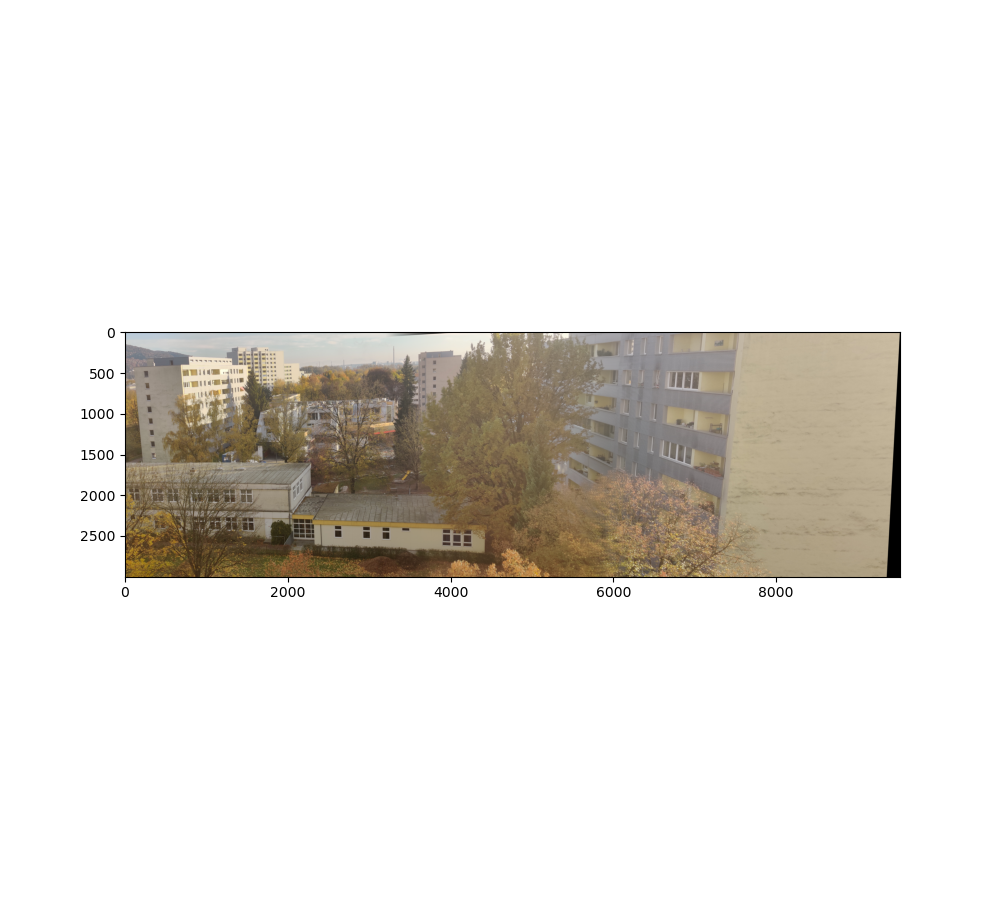

In [6]:
 #shows final stitched image   

final_result=cv2.cvtColor(fresult,cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(10, 9))
ax.imshow(final_result)
